<a href="https://colab.research.google.com/github/mwisechacha/Breast_cancer/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦮End-to-end Multi-class Dog Breed CLassification

This notebook builds an end-to-end multi-class image classifier using tensorflow 2.0 and TensorFlow Hub

## 1. Problem

Identifying the breed of a dog given the image of a dog

## 2. Data

The data we are using is from kaggle dog breed identification competition
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.



## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means therea are 120 different classes).
* There are around 10,000+ images in the training set(these images have labels)
* There are around 10,000+ images is the test set(these images have no labels, because we'll want to predict them)

### Get our workspace ready

* import TensorFlow 2.x👍
* Import TensorFlow hub👍
* Make sure we're using a GPU👍

In [ ]:
# if TensorFlow 2.x isn't the default in Colab
# try:
#   %tensorflow_version 2.x
# except Exception:
#   pass

In [ ]:
# import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# check for GPU availability
print("GPU", "available (YESSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.15.0
TF Hub version: 0.16.1
GPU available (YESSS!!!!)


## Getting our data ready (turning into tensors)

With all machine learning models, our data has to be in numerical format. Turning our images into tensors

1. accessing our data and checking the labels

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/dog_vision/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

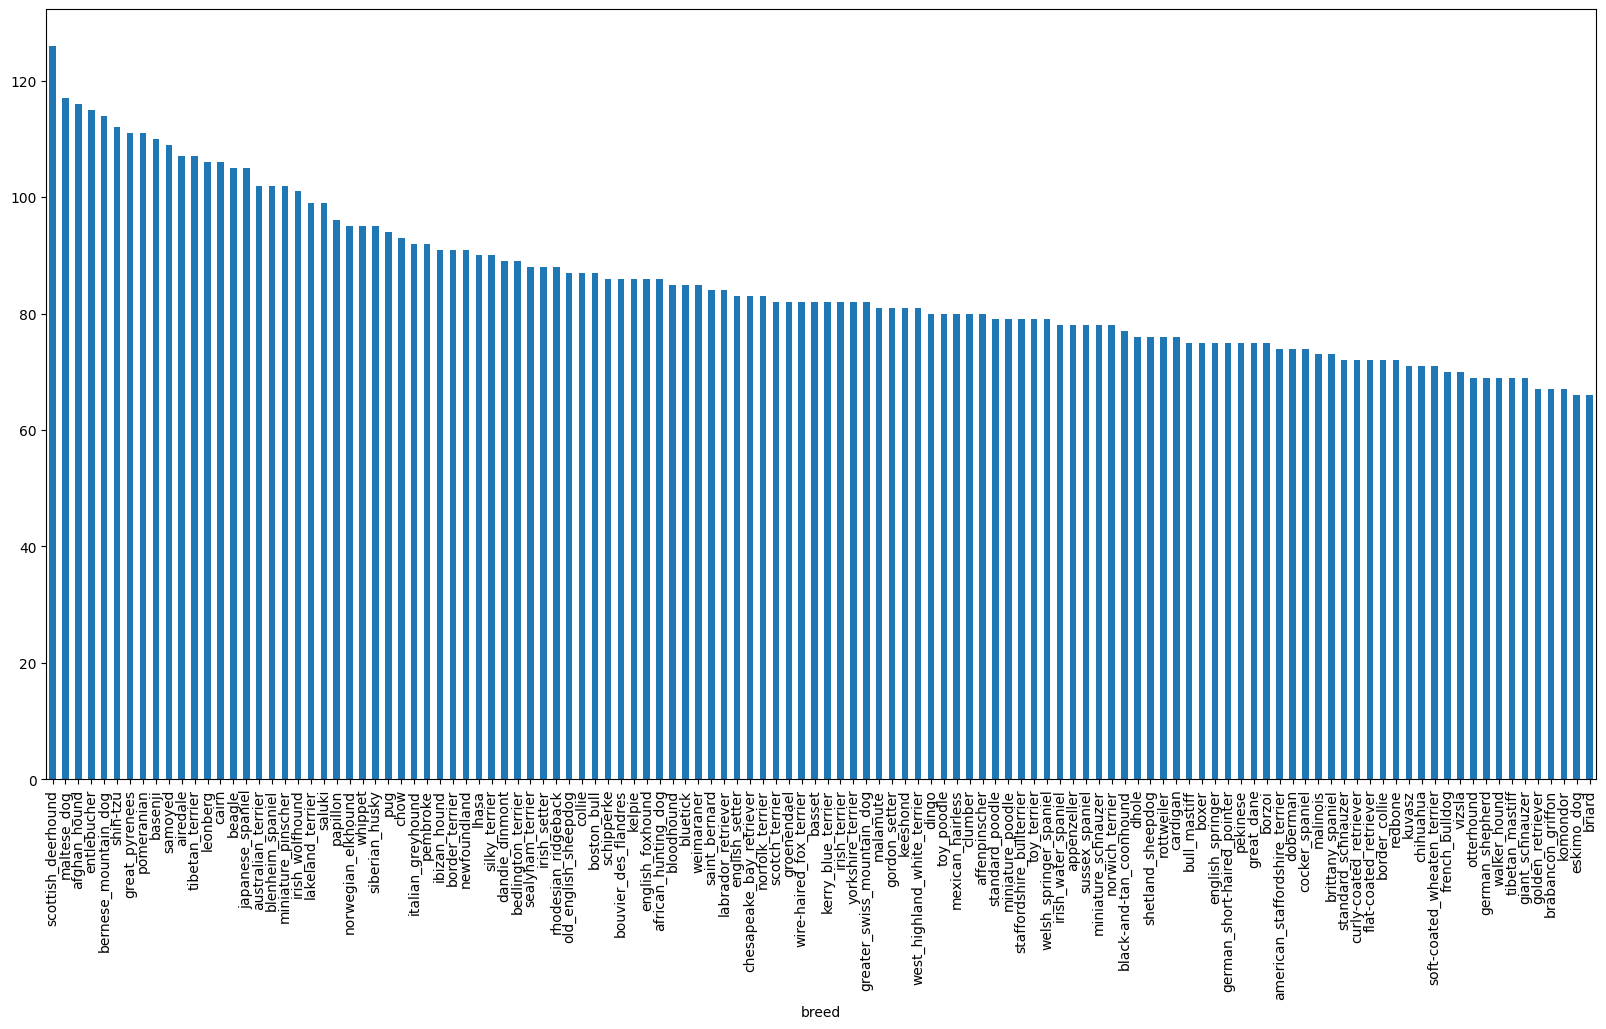

In [ ]:
# how many images are there on each bread?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
labels_csv['breed'].value_counts().median()

82.0

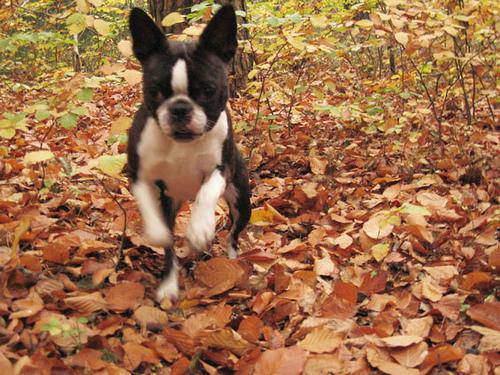

In [ ]:
# view an image
from IPython.display import Image
Image("drive/MyDrive/dog_vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

Geting a list of our image file pathnames

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/dog_vision/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/dog_vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog_vision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/dog_vision/dog-breed-identification/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do no match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


In [ ]:
import os

def reduce_files_in_directory(directory_path, required_number):
    files = os.listdir(directory_path)

    # Check if the number of files is already less than or equal to the required number
    if len(files) <= required_number:
        print("Number of files is already equal to or less than the required number.")
        return

    # Calculate the number of files to remove
    files_to_remove = len(files) - required_number

    # Remove excess files
    for i in range(files_to_remove):
        os.remove(os.path.join(directory_path, files[i]))
        print(f"Removed file: {files[i]}")

    print(f"Successfully reduced the number of files to {required_number}.")

# Example usage
directory_path = "drive/MyDrive/dog_vision/dog-breed-identification/train/"
required_number = 10222  # Change this to the desired number of files
reduce_files_in_directory(directory_path, required_number)

Number of files is already equal to or less than the required number.


In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

since we've now gotten our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# see if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames! ")
else:
  print("Number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames! 


In [ ]:
# find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every labels into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# example: turning boolean arrays into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset doesn't come with a validation set, we're going to create our own

In [ ]:
# setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

We're going to start off experimenting with ~ 1000 images and increase as needed

In [ ]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max: 10000, step:1000}

In [ ]:
# let's split data into train and validation
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# a look at the training data
X_train[:2], y_train[:2]

(['drive/MyDrive/dog_vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/dog_vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fa

### Preprocessing Images (turning images into tensors)

To preprocess our images into tensors we're going to write a functionn which does a few things:
1. Take an image filepath as input
2. Use tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our images (convert color channel values from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like


In [ ]:
# convert an image to a numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# turn an image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a tensor, let's create a function to preprocess them

In [ ]:
# Define image size
IMG_SIZE = 224

# create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and trun the image into a tensor
  """
  # read in an image file
  image = tf.io.read_file(image_path)
  # turn the jpeg image into numerical tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to our desired value(224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

### Turning our data into batches

why turn data into batches?

let's say you are trying to process 10,000+ images in one go... they all might not fit into memory
So that's why we do about 32(batch size) images at a time, but can be manually adjusted

In order to use tensorflow effectively, we need our data in the form of tensor tuples which look like this:
`(image, label)`.

In [ ]:
# create a simple function to return a tuple of tensors
def get_image_label(image_path, label):
  """
  takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuple of tensors in the form: `(image, label)`, let's  make a function to turn all our data (`X` & `y`) into batches!

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend,let's visualize them

In [ ]:
import matplotlib.pyplot as plt

# create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their lables from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(12, 12))
  # loop through 25 (for displaying 25 images)
  for i in range(25):
    # create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # display an image
    plt.imshow(images[i])
    # add the image label
    plt.title(unique_breeds[labels[i].argmax()])
    # turn the grid lines off

In [ ]:

len(train_images), len(train_labels)

(32, 32)

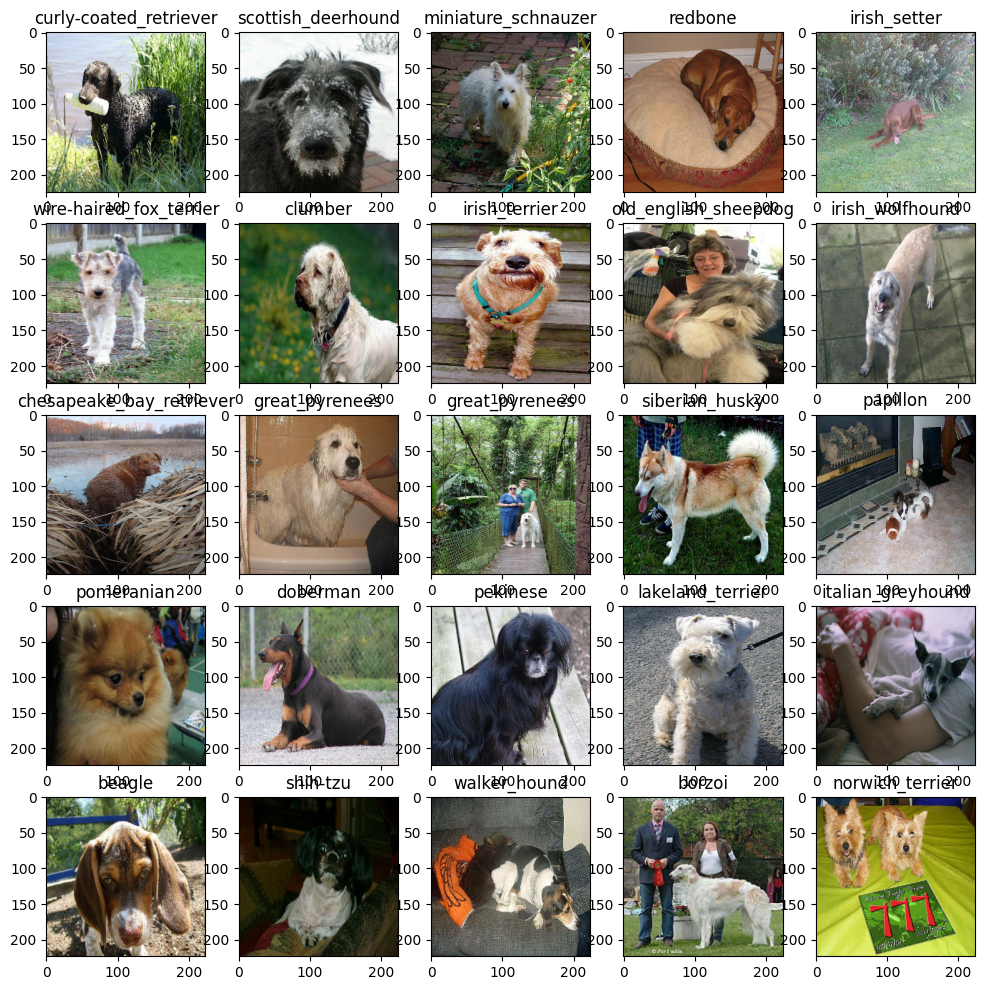

In [ ]:
# let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

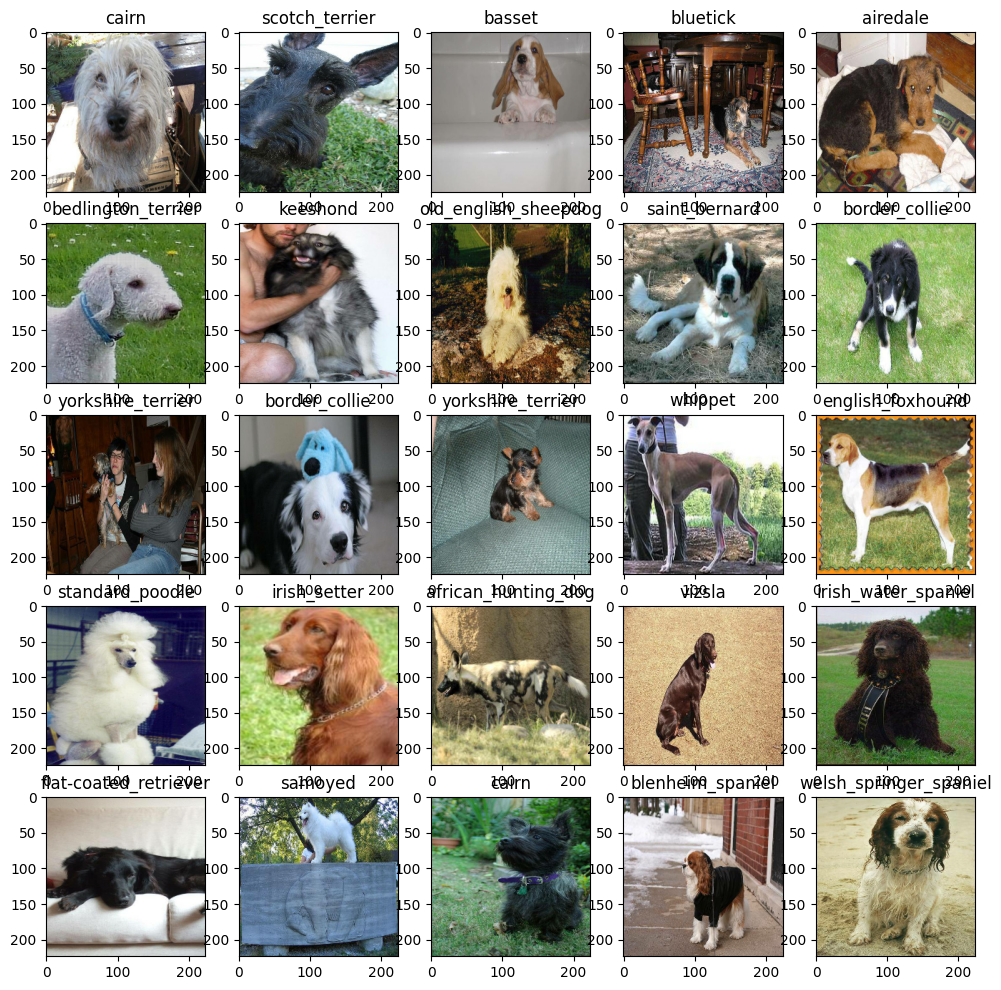

In [ ]:
# let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### Building a model

before we build a model, there are a few things we need to define:
* the input shape (our images shape, in the form of tensors) to our model.
* the output shape (image labels, in the form of tensors) of our model.
* the url of the model we want to use

In [ ]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# setup the output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# setup model url from TensorFlow Hub
MODEL_URL = ...